In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://dlcdn.apache.org/spark/spark-3.2.0/spark-3.2.0-bin-hadoop3.2.tgz
!tar xf spark-3.2.0-bin-hadoop3.2.tgz
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.2.0-bin-hadoop3.2"
!pip install -q findspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("Bitcoin").getOrCreate()
df = spark.read.csv("btc17-21.csv", header = 'true')
df.show()

+---+----------+-------------+-------------+--------+---------+-----+---------+-------------+------+------+-------+-------+-------+-------+------------------+----------+
|_c0|      time|        nBits|        value|in_count|out_count|count|value_min|    value_max|in_min|in_max|out_min|out_max|   Open|  Close|        Volume BTC|Volume USD|
+---+----------+-------------+-------------+--------+---------+-----+---------+-------------+------+------+-------+-------+-------+-------+------------------+----------+
|  0|1577754000|8843620987040|5739805858577|   47875|    64824|22834|        0| 319312747405|     1|   341|      1|   6794|7213.03|7241.81|             4.373|  31646.53|
|  1|1577757600|2834265498080|1936618920820|   14717|    25700| 7318|      546|  89520922991|     1|   240|      1|    961|7241.81|7218.15|             4.257|  30736.63|
|  2|1577761200|6125932957520|3151256057563|   29784|    39876|15817|      540|  96207131903|     1|   240|      1|   1187|7218.15|7216.57|           

In [ ]:
# Features engineering
from pyspark.sql import functions as F
df = (df
    .withColumn('time', df['time']+0)
    .withColumn('nBits', df['nBits']/df['count'])
    .withColumn('value', df['value']+0)
    .withColumn('in_count', df['in_count']+0)
    .withColumn('out_count', df['out_count']+0)
    .withColumn('count', df['count']+0)
    .withColumn('value_max', df['value_max']+0)
    .withColumn('in_max', df['in_max']+0)
    .withColumn('out_max', df['out_max']+0)
    .withColumn('Open', df['Open']+0)
    # .withColumn('value', df['value']/df['count'])
    .withColumn('Volume BTC', F.round(df['Volume BTC'], 5))
    .withColumn('Close', df['Close']+0)
    )
df = (df
    .select(
        F.col('time'), F.col('nBits'), F.col('value'), F.col('in_count'), F.col('out_count'), F.col('count'), F.col('value_max'), 
        F.col('in_max'), F.col('out_max'), F.col('Open'), F.col('Volume BTC'), F.col('Close').alias('Target'),
    )
    )
df.show()

+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+
|       time|      nBits|            value|in_count|out_count|  count|        value_max|in_max|out_max|   Open|Volume BTC| Target|
+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+
| 1.577754E9|3.8730056E8|5.739805858577E12| 47875.0|  64824.0|22834.0| 3.19312747405E11| 341.0| 6794.0|7213.03|     4.373|7241.81|
|1.5777576E9|3.8730056E8| 1.93661892082E12| 14717.0|  25700.0| 7318.0|  8.9520922991E10| 240.0|  961.0|7241.81|     4.257|7218.15|
|1.5777612E9|3.8730056E8|3.151256057563E12| 29784.0|  39876.0|15817.0|  9.6207131903E10| 240.0| 1187.0|7218.15|     35.06|7216.57|
|1.5777648E9|3.8730056E8|2.344403879425E12| 20579.0|  25298.0|10985.0|   8.950576166E10| 240.0|  185.0|7216.57|     7.914|7223.75|
|1.5777684E9|3.8730056E8|3.237367959322E12| 24148.0|  24417.0|10027.0|           5.

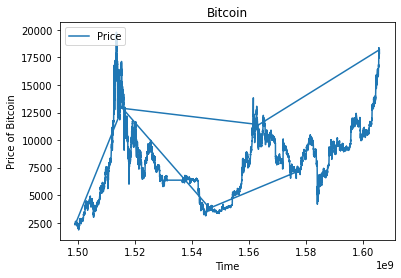

In [ ]:
import matplotlib.pyplot as plt

y = [val.Target for val in df.select('Target').collect()]
x = [val.time for val in df.select('time').collect()]

plt.plot(x, y)

plt.ylabel('Price of Bitcoin')
plt.xlabel('Time')
plt.title('Bitcoin')
plt.legend(['Price'], loc='upper left')

plt.show()

In [ ]:
# Feature aggregation
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC'], outputCol="features")
df = assembler.transform(df)
df.show()

+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+--------------------+
|       time|      nBits|            value|in_count|out_count|  count|        value_max|in_max|out_max|   Open|Volume BTC| Target|            features|
+-----------+-----------+-----------------+--------+---------+-------+-----------------+------+-------+-------+----------+-------+--------------------+
| 1.577754E9|3.8730056E8|5.739805858577E12| 47875.0|  64824.0|22834.0| 3.19312747405E11| 341.0| 6794.0|7213.03|     4.373|7241.81|[1.577754E9,3.873...|
|1.5777576E9|3.8730056E8| 1.93661892082E12| 14717.0|  25700.0| 7318.0|  8.9520922991E10| 240.0|  961.0|7241.81|     4.257|7218.15|[1.5777576E9,3.87...|
|1.5777612E9|3.8730056E8|3.151256057563E12| 29784.0|  39876.0|15817.0|  9.6207131903E10| 240.0| 1187.0|7218.15|     35.06|7216.57|[1.5777612E9,3.87...|
|1.5777648E9|3.8730056E8|2.344403879425E12| 20579.0|  25298.0|10985.0|   8.950576166E10|

In [ ]:
# Split data into training set and testing set
from pyspark.ml.regression import *
# 2020-10-20(1603234800)
# 2020-08-01(1596240000)
X_train = df.filter(F.col('time') < "1596240000")
X_test = df.filter(F.col('time') > "1596240000")
X_test.show()

+-----------+------------+-----------------+--------+---------+-------+----------------+------+-------+--------+----------+--------+--------------------+
|       time|       nBits|            value|in_count|out_count|  count|       value_max|in_max|out_max|    Open|Volume BTC|  Target|            features|
+-----------+------------+-----------------+--------+---------+-------+----------------+------+-------+--------+----------+--------+--------------------+
|1.5962436E9|3.86970872E8|4.511210992578E12| 36086.0|  42679.0|15023.0|2.69061276955E11| 762.0|  250.0|11268.73|     15.36|11277.84|[1.5962436E9,3.86...|
|1.5962472E9|3.86970872E8| 3.93188978885E12| 53576.0|  39015.0|12141.0|2.18421956191E11|1021.0| 1420.0|11277.84|     18.67|11344.96|[1.5962472E9,3.86...|
|1.5962508E9|3.86970872E8|3.204257837794E12| 16272.0|  29650.0| 7215.0|2.18363458555E11| 660.0| 3443.0|11344.96|     27.89|11372.69|[1.5962508E9,3.86...|
|1.5962544E9|3.86970872E8|2.791870271971E12| 33570.0|  26075.0| 9215.0|2.185

In [50]:
# Applying a gradient boosted tree regressor
gbt = GBTRegressor(labelCol="Target")
fitted = gbt.fit(X_train)
yhat_gbt = (fitted.transform(X_test))
yhat_gbt.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|11277.84|11417.117692269652|
|11344.96|11415.757721307777|
|11372.69|11411.459899460173|
|11401.16|11411.459899460173|
|11624.63|11415.124745021953|
|11654.12|  11413.0372332224|
|11671.94|  11413.0372332224|
|11690.85|  11413.0372332224|
|11713.76|11417.117692269652|
|11629.42|11390.624224942449|
|11662.01|11419.140111129153|
|11685.48|11417.117692269652|
|11535.66|11415.540358507425|
|11618.26|  11413.0372332224|
|11646.26|  11413.0372332224|
|11656.39|  11388.8191688833|
|11746.04|11417.117692269652|
|11686.82|11417.117692269652|
| 11801.2|  11388.8191688833|
| 11852.5|11912.638558400577|
+--------+------------------+
only showing top 20 rows



In [51]:
# Evaluations of gradient boosted tree regressor
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_gbt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_gbt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_gbt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 1008.6736024329675
MAE is 540.468555493137
R² is 0.7044948643516799


In [ ]:
# Importance of each features in GBTRegressor
import pandas as pd
score = fitted.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.985589
time,0.004377
nBits,0.001993
in_count,0.001584
value,0.001224
in_max,0.001222
out_max,0.001194
Volume BTC,0.000901
count,0.000878
value_max,0.000759


In [ ]:
# Applying Decision Tree Regressor
dt = DecisionTreeRegressor(featuresCol = 'features', labelCol="Target")
fitted_dt = dt.fit(X_train)
yhat_dt = (fitted_dt.transform(X_test))
yhat_dt.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|11277.84|11089.582181818188|
|11344.96|11089.582181818188|
|11372.69|11089.582181818188|
|11401.16|11089.582181818188|
|11624.63|11858.322857142855|
|11654.12|11858.322857142855|
|11671.94|11858.322857142855|
|11690.85|11858.322857142855|
|11713.76|11858.322857142855|
|11629.42|11858.322857142855|
|11662.01|11858.322857142855|
|11685.48|11858.322857142855|
|11535.66|11858.322857142855|
|11618.26|11858.322857142855|
|11646.26|11858.322857142855|
|11656.39|11858.322857142855|
|11746.04|11858.322857142855|
|11686.82|11858.322857142855|
| 11801.2|11858.322857142855|
| 11852.5|11858.322857142855|
+--------+------------------+
only showing top 20 rows



In [ ]:
# Evaluations of Decision Tree Regressor Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_dt)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_dt, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_dt, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 804.1641231665913
MAE is 506.2133008322936
R² is 0.8121751244192765


In [ ]:
# Importance of each features in Decision Tree Regressor
import pandas as pd
score = fitted_dt.featureImportances.toArray()
features = ['time', 'nBits', 'value', 'in_count', 'out_count', 'count', 'value_max', 'in_max', 'out_max', 
                                       'Open', 'Volume BTC']
features_score = (pd.DataFrame(dict(zip(features, score)), range(1))
  .T.rename(columns={0:'Score'})
  .sort_values("Score", ascending =False)
  )
features_score

,Score
Open,0.996160
time,0.002695
Volume BTC,0.000747
value,0.000289
nBits,0.000084
value_max,0.000024
in_count,0.000000
out_count,0.000000
count,0.000000
in_max,0.000000


In [ ]:
# Applying Linear Regression Model
lr = LinearRegression(featuresCol = 'features', labelCol="Target")
fitted_lr = lr.fit(X_train)
yhat_lr = (fitted_lr.transform(X_test))
yhat_lr.select(F.col('Target'), F.col('prediction')).show()

+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|11277.84|11270.271103389841|
|11344.96|11276.242585064107|
|11372.69|11344.284719875192|
|11401.16|11371.717414603565|
|11624.63| 11392.58338453688|
|11654.12| 11623.63867905776|
|11671.94|11653.088404391949|
|11690.85|11674.040694383351|
|11713.76|11688.956816595242|
|11629.42|11716.400609254264|
|11662.01|11629.768024077493|
|11685.48|11662.181360212238|
|11535.66| 11681.54530523663|
|11618.26|11537.441829807078|
|11646.26| 11621.54739006757|
|11656.39|11647.814532284912|
|11746.04|11656.811947567821|
|11686.82|11746.055401405336|
| 11801.2|11687.306675041173|
| 11852.5|11802.594062362226|
+--------+------------------+
only showing top 20 rows



In [ ]:
# Evaluations of Linear Regression Model
from pyspark.ml.evaluation import RegressionEvaluator
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(yhat_lr)
print('RMSE is', rmse)
mae = eval.evaluate(yhat_lr, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(yhat_lr, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 67.2952421390483
MAE is 42.394551302940016
R² is 0.998684676913956


In [52]:
# Optimise the model with Kfold and GridSearch Method(GBT)
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [5, 8, 10, 12])
             .addGrid(gbt.maxBins, [32, 64])
             .build())
cv = CrossValidator(estimator=gbt,
                          estimatorParamMaps=paramGrid,
                          evaluator=eval,
                          numFolds=3)  
cvModel = cv.fit(X_train)
cvYhat = cvModel.transform(X_test)

cvEval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = cvEval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = cvEval.evaluate(cvYhat, {cvEval.metricName: "mae"})
print('MAE is', mae)
r2 = cvEval.evaluate(cvYhat, {cvEval.metricName: "r2"})
print('R² is', r2)

cvYhat.select(F.col('Target'), F.col('prediction')).show()

RMSE is 524.8230418791343
MAE is 304.3201622382396
R² is 0.9200000877395884
+--------+------------------+
|  Target|        prediction|
+--------+------------------+
|11277.84| 11299.06598273732|
|11344.96| 11299.06598273732|
|11372.69| 11295.49701777823|
|11401.16|11287.207602693286|
|11624.63|11501.619623662658|
|11654.12|11501.619623662658|
|11671.94|11531.249855768872|
|11690.85|11504.879103318866|
|11713.76|11516.239634392954|
|11629.42|11502.493609739511|
|11662.01|11508.315427108588|
|11685.48|11516.239634392954|
|11535.66|11519.499114049162|
|11618.26| 11497.10805944139|
|11646.26|11500.367539097599|
|11656.39| 11497.10805944139|
|11746.04|11519.499114049162|
|11686.82|11550.381430720436|
| 11801.2|11530.822424867014|
| 11852.5| 12168.84946751351|
+--------+------------------+
only showing top 20 rows



In [54]:
# Evaluations of Cross Validation
eval = RegressionEvaluator(labelCol='Target', predictionCol='prediction', metricName='rmse')
rmse = eval.evaluate(cvYhat)
print('RMSE is', rmse)
mae = eval.evaluate(cvYhat, {eval.metricName: "mae"})
print('MAE is', mae)
r2 = eval.evaluate(cvYhat, {eval.metricName: "r2"})
print('R² is', r2)

RMSE is 524.8230418791343
MAE is 304.3201622382396
R² is 0.9200000877395884
